# Pointwise Reliability: Density, Distance - Euclidean
Uses distances between a new instance and all preprocessed training points to assess reliability

## Workflow:
- Calculate the Euclidean distances from the instance to all points in the training data
- Identify points in the training set that belong to the same class as the predicted label for the new instance
- Count how many of these points are within a defined `distance_threshold` of the new instance (`same_label_points`)
- Compute reliability:
  - reliability=  `same_label_points` / `minimum_cluster_units`
    - `minimum_cluster_units` <- param 
    - If the `same_label_points` size is larger than the threshold (minimum units): reliability = 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.neighbors import NearestNeighbors
from utils.reliability_visualizer import ReliabilityVisualizer

###########################################################
# Load Classifier and Data
###########################################################
pipeline = joblib.load('lr_pipeline_classifier.pkl')
training_data = pd.read_excel("dataset/data_train.xlsx")

y_train = training_data['Morte']
X_train = training_data.drop(columns=['Morte'])
X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

In [2]:
###########################################################
# Reliability Calculation (Density - Distance: Euclidean)
###########################################################
def reliability_distance_based(new_instance, X_train_preprocessed, y_train, predicted_label, distance_threshold=0.10, target_instances=20):
    """
    Calculate the reliability based on euclidean distance and min. number of neighbors

    Reliability = 
        if (neighbors_new_instance < target_instances) 
            neighbors_new_instance / target_instances  
        else
            1

    Parameters:
    - new_instance: Preprocessed new instance.
    - X_train_preprocessed: Preprocessed training data.
    - y_train: Training labels.
    - predicted_label: Predicted class label of the new instance.
    - distance_threshold: The distance threshold for considering neighbors.
    - target_instances: Number of instances for full reliability.

    Returns:
    - reliability_score: [0; 1] reliability.
    """
    distances = np.linalg.norm(X_train_preprocessed - new_instance, axis=1)
    
    same_class_neighbors = (y_train == predicted_label)
    close_neighbors = np.sum((distances <= distance_threshold) & same_class_neighbors)
    
    reliability_score = min(close_neighbors / target_instances, 1.0)
    return reliability_score

In [3]:
###########################################################
# Classification and Reliability
###########################################################
def classify_and_check_reliability(new_data, pipeline, X_train_preprocessed, y_train, distance_threshold=0.10, target_instances=20):
    """
    Predicts the class and assesses reliability of a new instance.

    Parameters:
    - new_data (pd.DataFrame): DataFrame with the same columns as training data.
    - pipeline (Pipeline): The loaded pipeline for preprocessing and classification.
    - X_train_preprocessed: Preprocessed training data.
    - y_train: Training labels.
    - distance_threshold: The distance threshold for considering neighbors.
    - target_instances: The number of instances required for full reliability.

    Returns:
    - dict: Contains prediction and reliability score.
    """

    # Preprocess & Predict
    new_data_preprocessed = pipeline.named_steps['preprocessor'].transform(new_data)    
    predicted_label = pipeline.named_steps['classifier'].predict(new_data_preprocessed)[0]
    
    # Calculate reliability
    reliability_score = reliability_distance_based(
        new_data_preprocessed[0],
        X_train_preprocessed,
        y_train,
        predicted_label,
        distance_threshold,
        target_instances
    )
    
    return {
        "predicted_label": predicted_label,
        "reliability_score": reliability_score
    }

In [4]:
###########################################################
#  Load and Test with Unseen Data
###########################################################
validation_data = pd.read_excel("dataset/data_validation.xlsx")
results = []

##############
### TODO: Adjust

distance_threshold = 0.08954895293389985
target_instances = 9

for _, instance in validation_data.iterrows():
    true_label = instance['Morte']
    instance_df = pd.DataFrame([instance.drop(labels=['Morte'])])
    result = classify_and_check_reliability(
        instance_df,
        pipeline,
        X_train_preprocessed,
        y_train,
        distance_threshold=distance_threshold,
        target_instances=target_instances
    )
    result['true_label'] = true_label
    results.append(result)

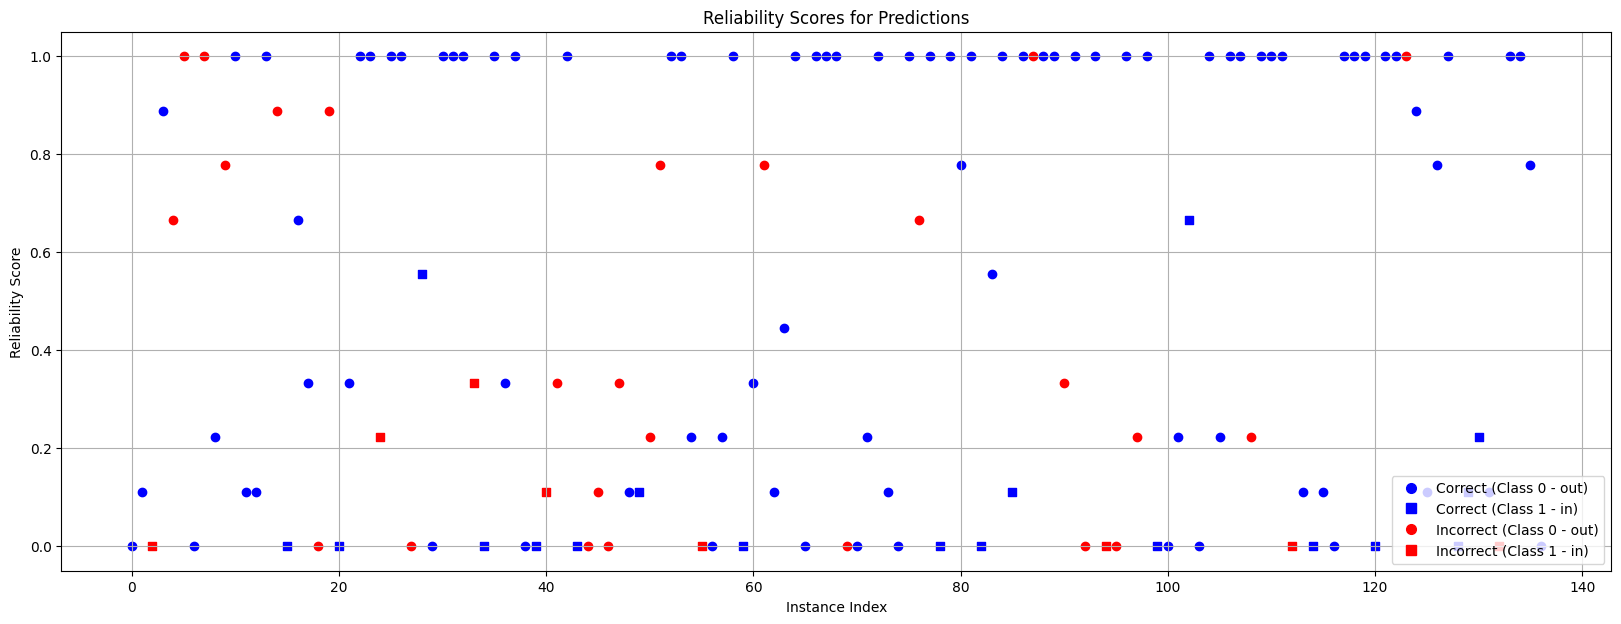

In [5]:
###########################################################
# Results
###########################################################
results_df = pd.DataFrame(results)

visualizer = ReliabilityVisualizer(results_df=results_df)
visualizer.plot_reliability_scores((20, 7))

In [6]:
reliability_table_df = visualizer.get_reliability_table_5()
print(reliability_table_df)

     Reliability  Correct (0)  Incorrect (0)  Correct (1)  Incorrect (1)
0   [0.00, 0.05]           12              7           12              5
1   ]0.05, 0.10]            0              0            0              0
2   ]0.10, 0.15]           10              1            3              1
3   ]0.15, 0.20]            0              0            0              0
4   ]0.20, 0.25]            6              3            1              1
5   ]0.25, 0.30]            0              0            0              0
6   ]0.30, 0.35]            4              3            0              1
7   ]0.35, 0.40]            0              0            0              0
8   ]0.40, 0.45]            1              0            0              0
9   ]0.45, 0.50]            0              0            0              0
10  ]0.50, 0.55]            0              0            0              0
11  ]0.55, 0.60]            1              0            1              0
12  ]0.60, 0.65]            0              0       

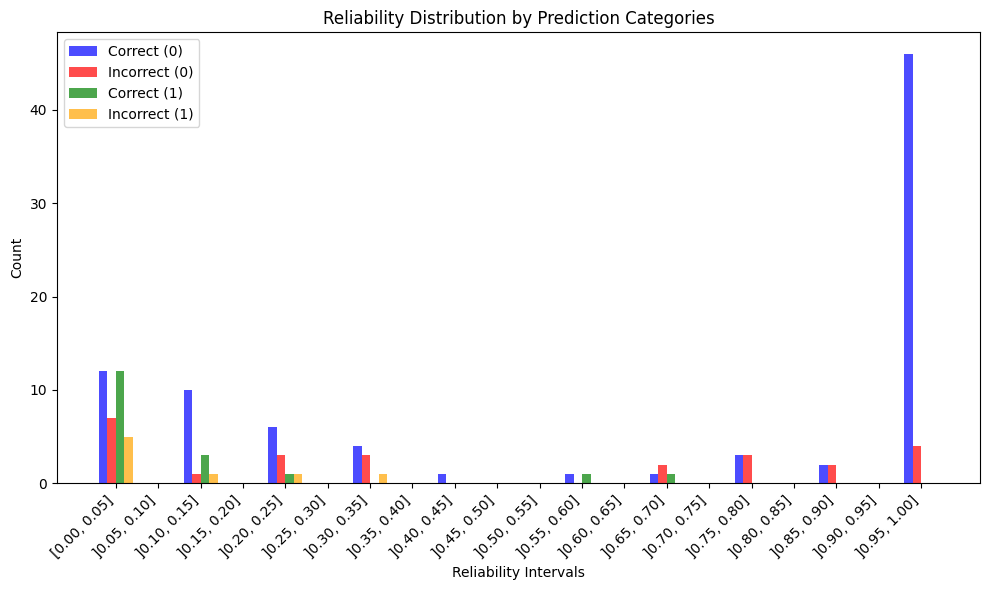

In [7]:
visualizer.plot_table_graph(reliability_table_df)

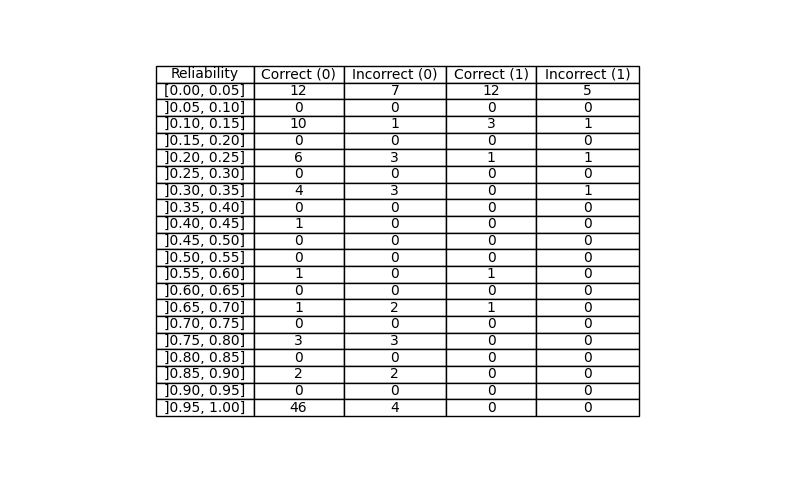

In [8]:
visualizer.plot_table_image(reliability_table_df)

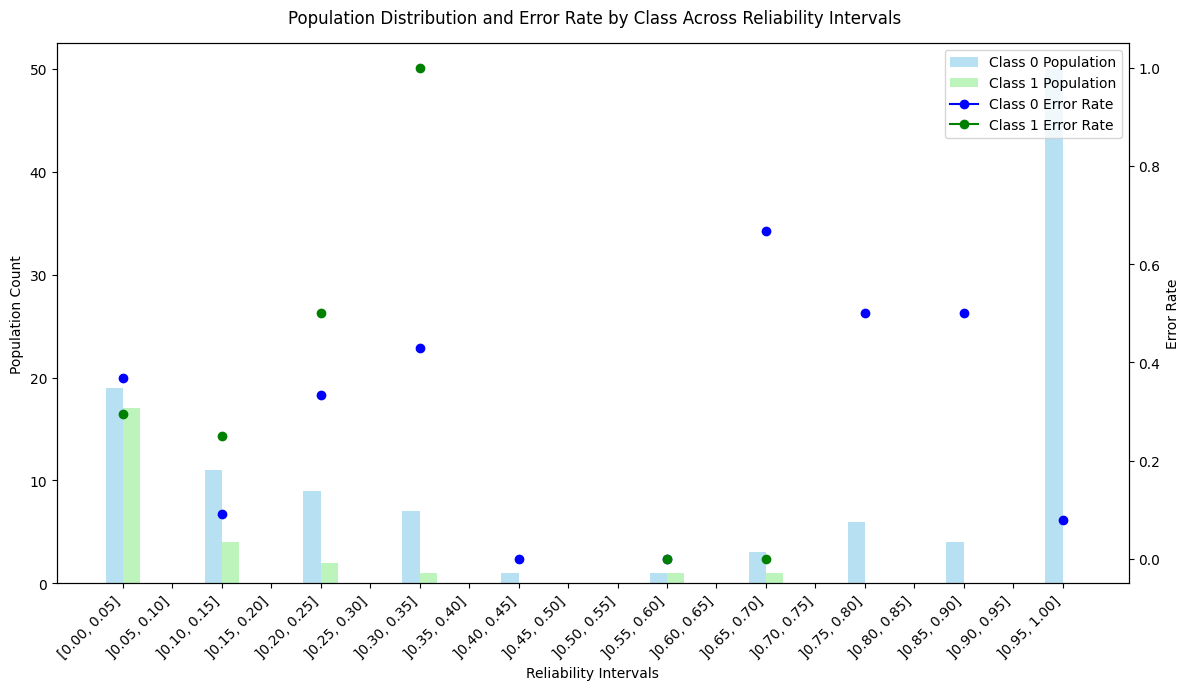

In [9]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_df)

### 10

In [10]:
reliability_table_10_df = visualizer.get_reliability_table_10()
print(reliability_table_10_df)

    Reliability  Correct (0)  Incorrect (0)  Correct (1)  Incorrect (1)
0  [0.00, 0.10]           12              7           12              5
1  ]0.10, 0.20]           10              1            3              1
2  ]0.20, 0.30]            6              3            1              1
3  ]0.30, 0.40]            4              3            0              1
4  ]0.40, 0.50]            1              0            0              0
5  ]0.50, 0.60]            1              0            1              0
6  ]0.60, 0.70]            1              2            1              0
7  ]0.70, 0.80]            3              3            0              0
8  ]0.80, 0.90]            2              2            0              0
9  ]0.90, 1.00]           46              4            0              0


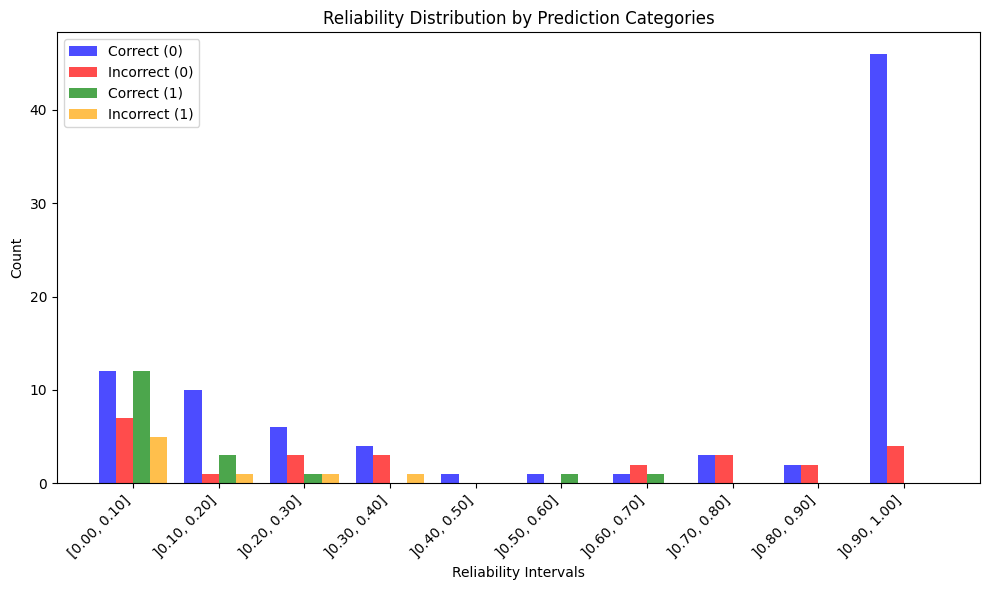

In [11]:
visualizer.plot_table_graph(reliability_table_10_df)

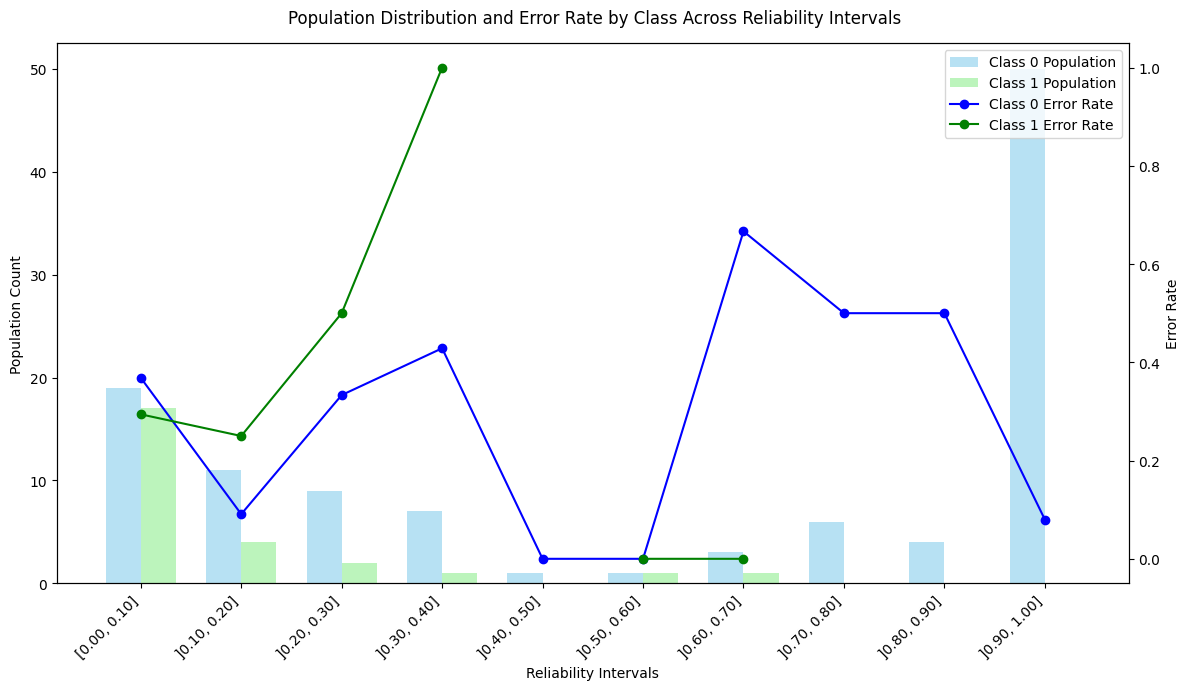

In [12]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_10_df)

Sample reliability interval assignment:
   reliability_score reliability_interval
0           0.000000        (-0.001, 0.1]
1           0.111111           (0.1, 0.2]
2           0.000000        (-0.001, 0.1]
3           0.888889           (0.8, 0.9]
4           0.666667           (0.6, 0.7]
5           1.000000           (0.9, 1.0]
6           0.000000        (-0.001, 0.1]
7           1.000000           (0.9, 1.0]
8           0.222222           (0.2, 0.3]
9           0.777778           (0.7, 0.8]


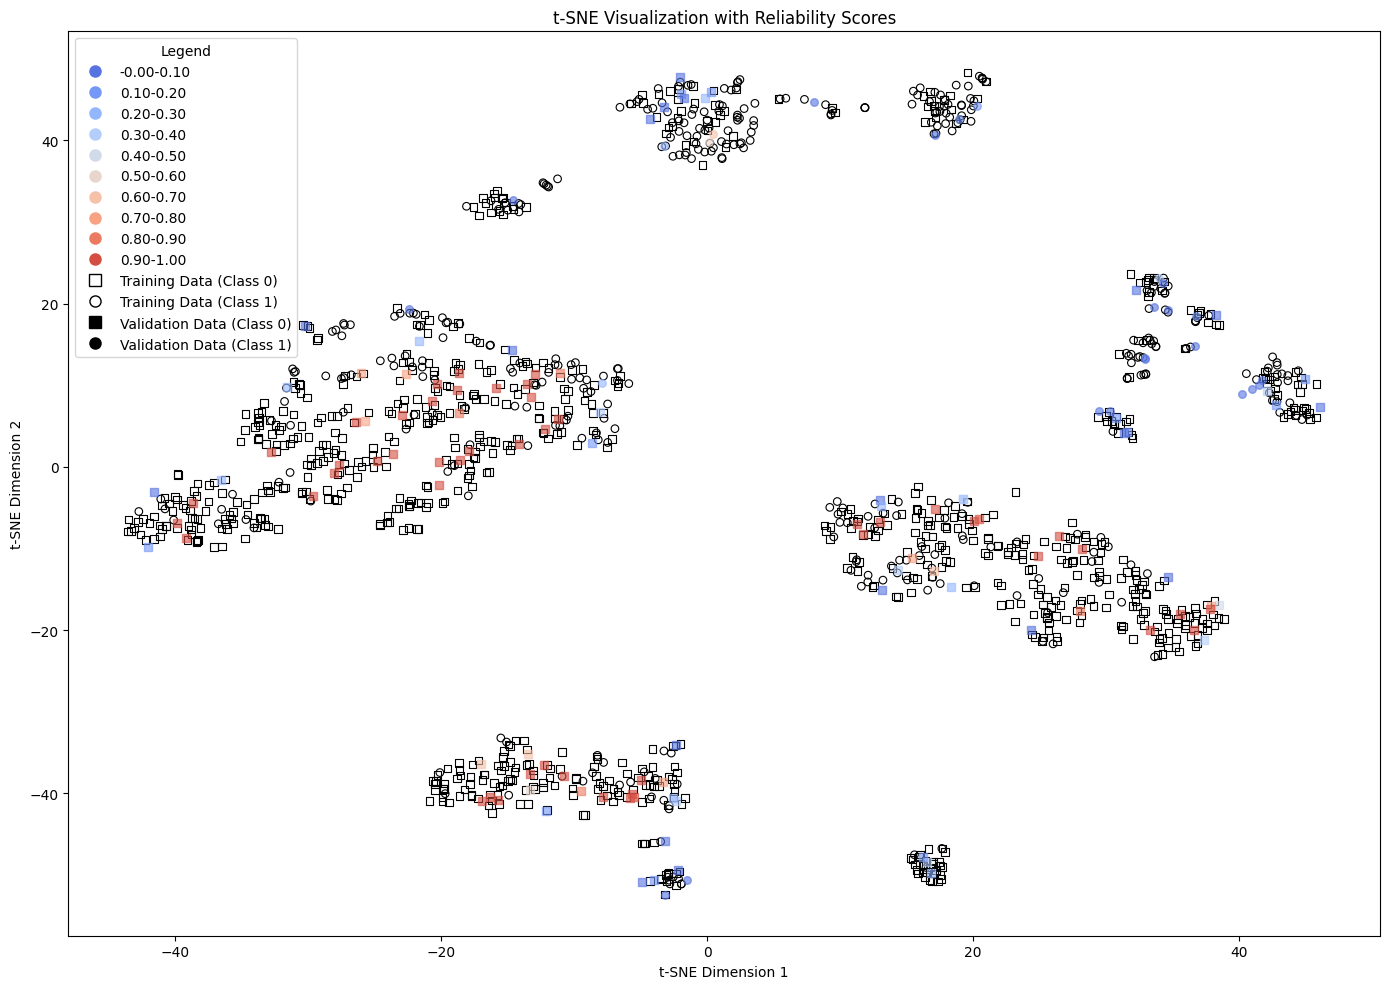

In [13]:
visualizer.plot_tsne_with_reliability(
    X_train_preprocessed, validation_data, y_train, pipeline
)